In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from poltilereconstructor.align_images.histology_image import HistologyImage
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
current_tile = 'A1'
current_histo = 'histology'
parameters = {'level': 6, 'histo_histo': True, 'border_size': 600}
path_mrxs = f'D:/Chicago/HT_sample/{current_histo}/data/{current_tile}_{current_histo}.mrxs'

In [4]:
if current_histo == 'HE':
    histology_image = HistologyImage(path_mrxs, parameters = parameters)

In [5]:
gs_image_mskd = rgb2gray(rgb_image_mskd)

NameError: name 'rgb2gray' is not defined

In [174]:
border_size = 600
gs_image_border = cv2.copyMakeBorder(
    gs_image_mskd,
    top=border_size,
    bottom=border_size,
    left=border_size,
    right=border_size,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0])

In [175]:
gs_image_border.shape

(2501, 4460)

In [176]:
gs_image_mskd.shape

(1301, 3260)

In [177]:
def displace(image, image_mskd, parameters = None):
    border_size = 600
    
    border_displaced = np.zeros(image.shape)
    
    if parameters is None:
        parameters = {}
        displacement_x = random.randint(-border_size, border_size)
        displacement_y = random.randint(-border_size, border_size)
        angle = random.uniform(-5, 5)

        parameters['displacement_x'] = displacement_x
        parameters['displacement_y'] = displacement_y
        parameters['angle'] = angle
    
    border_displaced[border_size + parameters['displacement_x']: border_displaced.shape[0] - border_size + parameters['displacement_x'], 
                    border_size + parameters['displacement_y']: border_displaced.shape[1] - border_size + parameters['displacement_y']] = image_mskd
        
    border_rotated = np.array(Image.fromarray(border_displaced.astype(np.uint8)).rotate(parameters['angle'], resample=Image.NEAREST, expand=0))

    # Apply elastic transformation
    alpha = 10  # Scaling factor for deformation
    sigma = 10   # Standard deviation of the Gaussian filter
    if 'maps_deformation' in parameters:
        return border_rotated, _
        border_deformed, maps_deformation = elastic_transform(border_rotated, alpha, sigma, indices = parameters['maps_deformation'])
    else:
        border_deformed, maps_deformation = elastic_transform(border_rotated, alpha, sigma)
        parameters['maps_deformation'] = maps_deformation

    return border_deformed, parameters

In [178]:
border_deformed, parameters = displace(gs_image_border, gs_image_mskd, parameters = None)

In [182]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

def elastic_transform(image, alpha, sigma, random_state=None, indices=None):
    """
    Apply random elastic deformation to the input image.
    
    Parameters:
        image: Input 2D or 3D image (e.g., RGB, RGBA)
        alpha: Scaling factor for the intensity of deformation (larger = more intense deformation)
        sigma: Standard deviation of the Gaussian kernel (controls smoothness of deformation)
        random_state: Optional; random seed for reproducibility
        
    Returns:
        Transformed image with elastic deformation applied.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)
    
    shape = image.shape
    if len(shape) == 2:  # Grayscale image
        h, w = shape
    elif len(shape) == 3:  # RGB/RGBA image
        h, w, c = shape
    
    # Generate random displacement fields for x and y directions
    dx = random_state.rand(h, w) * 2 - 1  # Random values between -1 and 1
    dy = random_state.rand(h, w) * 2 - 1
    
    # Smooth displacement fields using a Gaussian filter
    dx = ndi.gaussian_filter(dx, sigma, mode="constant", cval=0) * alpha
    dy = ndi.gaussian_filter(dy, sigma, mode="constant", cval=0) * alpha
    
    # Create a meshgrid of coordinates
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Apply the displacements to the meshgrid
    if indices is None:
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    
    # Map the image pixels according to the displacement
    if len(shape) == 2:
        # For grayscale images
        distorted_image = ndi.map_coordinates(image, indices, order=1, mode='reflect').reshape((h, w))
    else:
        # For RGB/RGBA images, apply transformation to each channel
        distorted_image = np.zeros_like(image)
        for i in range(c):
            distorted_image[..., i] = ndi.map_coordinates(image[..., i], indices, order=1, mode='reflect').reshape((h, w))
    
    return distorted_image, indices



In [183]:
reference_image = gs_image_border
moving_image = fixed_arr_border_deformed

In [6]:
%load_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np

import torch

from PIL import Image
import cv2

import matplotlib.pyplot as plt

import time

from comparemethods import plot_results, match_oanet, matcher, helpers, alignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
type_alignment = 'histology'
folder_data = f'./{type_alignment}/data'
folder_output = f'./{type_alignment}/output'
current_tile = 'A1'
os.makedirs(f'./{folder_data}/{current_tile}', exist_ok = True)

path_coordinates = f'./{type_alignment}/results/{current_tile}/coordinates'
path_plot = f'./{type_alignment}/results/{current_tile}/plots'
os.makedirs(f'./{type_alignment}/results/{current_tile}', exist_ok = True)
os.makedirs(path_coordinates, exist_ok = True)
os.makedirs(f'./{type_alignment}/results/{current_tile}/plots', exist_ok = True)
os.makedirs(f'./{type_alignment}/results/{current_tile}/distances', exist_ok = True)

In [29]:
reference_image, moving_image = helpers.prepare_img_polarimetry(folder_data, current_tile, type_alignment)

In [30]:
from comparemethods import plot_results, match_oanet, matcher, helpers, alignment

Processing time: 5.11 ± 0.00 s


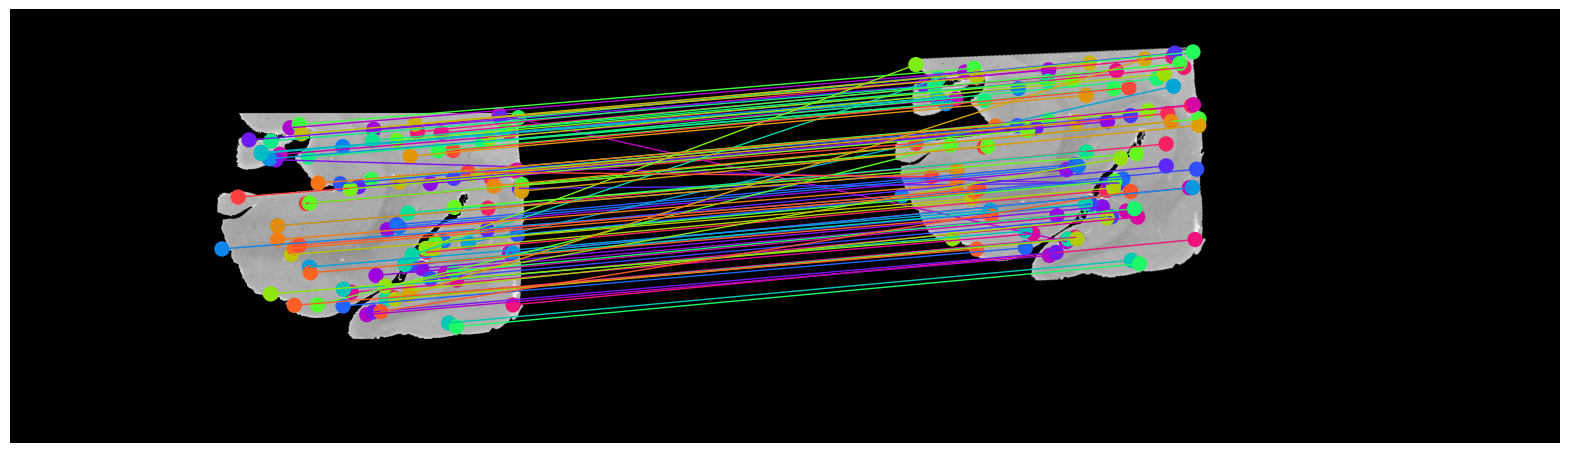

In [214]:
sift_mnn_matched_points_ref, sift_mnn_matched_points_mov = matcher.match('sift', 'mnn', 1, current_tile, type_alignment)
helpers.write_coordinates_txt(f'{path_coordinates}/sift_mnn.txt', 
                              [sift_mnn_matched_points_ref, sift_mnn_matched_points_mov])
plot_results.plot_results(reference_image, moving_image, 
                          sift_mnn_matched_points_ref, sift_mnn_matched_points_mov, f'{path_plot}/sift_mnn.pdf')

Processing time: 2.24 ± 0.00 s


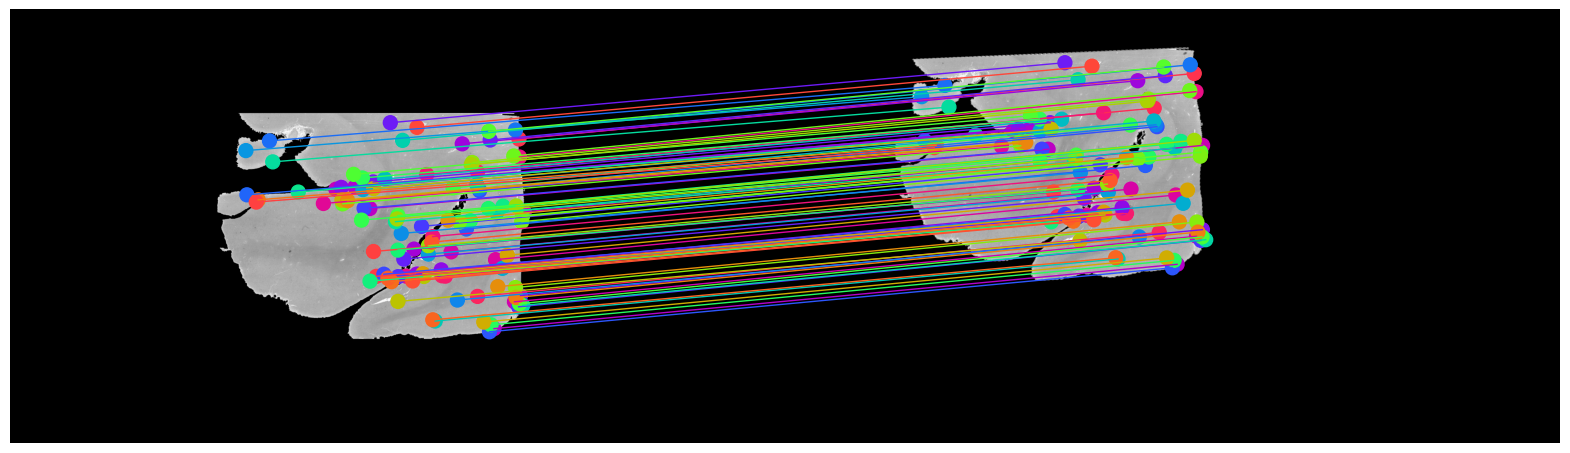

In [235]:
sp_oanet_matched_points_ref, sp_oanet_matched_points_mov = matcher.match('superpoint', 'oanet', 1, current_tile, type_alignment)
helpers.write_coordinates_txt(f'{path_coordinates}/sp_oanet.txt', [sp_oanet_matched_points_ref, sp_oanet_matched_points_mov])
plot_results.plot_results(reference_image, moving_image, sp_oanet_matched_points_ref, 
                          sp_oanet_matched_points_mov, f'{path_plot}/sp_oanet.pdf')

Processing time: 4.63 ± 0.00 s


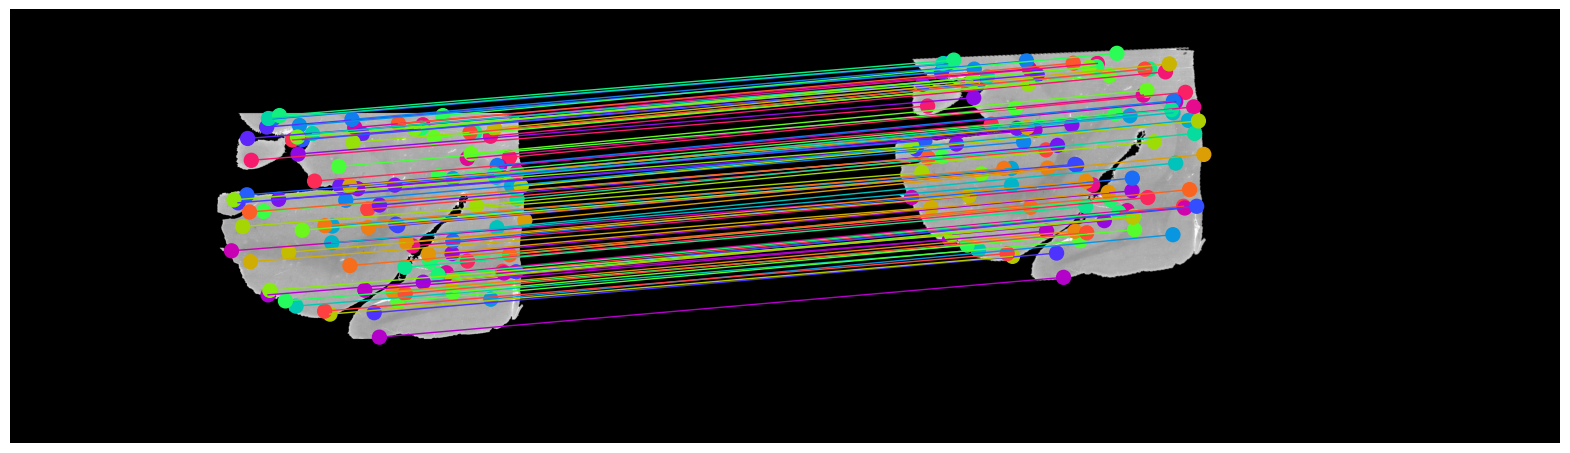

In [189]:
sp_sg_matched_points_ref, sp_sg_matched_points_mov = matcher.match('superpoint', 'superglue', 1, current_tile, type_alignment)
helpers.write_coordinates_txt(f'{path_coordinates}/sp_sg.txt', [sp_sg_matched_points_ref, sp_sg_matched_points_mov])
plot_results.plot_results(reference_image, moving_image, sp_sg_matched_points_ref, 
                          sp_sg_matched_points_mov, f'{path_plot}/sp_sg.pdf')

In [236]:
random_indices = np.random.choice(sp_oanet_matched_points_ref.shape[0], size=256 - 1, replace=False)

In [237]:
to_propagate = np.zeros(gs_image_mskd.shape, dtype = np.uint8)
for idx, point in enumerate(sp_oanet_matched_points_ref.astype(np.uint16)[random_indices]):
    try:
        assert np.sum(to_propagate[point[1]-1 - border_size:point[1]+2 - border_size, point[0]-1 - border_size:point[0]+2 - border_size]) == 0
        to_propagate[point[1]-1-border_size:point[1]+2-border_size, point[0]-1-border_size:point[0]+2-border_size] = idx + 1
    except AssertionError:
        print(idx)
    
border_size = 600
gs_image_border = cv2.copyMakeBorder(
    to_propagate,
    top=border_size,
    bottom=border_size,
    left=border_size,
    right=border_size,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0])

In [238]:
propagated, _ = displace(gs_image_border, to_propagate, parameters = parameters)

In [239]:
import math

distances = []
for idx, point in enumerate(sp_oanet_matched_points_mov.astype(np.uint16)[random_indices]):
    try:
        
        assert len(np.where(propagated == idx + 1)[1]) > 0
        point_propagated = round(np.mean(np.where(propagated == idx + 1)[1])), round(np.mean(np.where(propagated == idx + 1)[0]))
        distance = math.sqrt((point_propagated[0] - point[0])**2 + (point_propagated[1] - point[1])**2)
        distances.append(distance)
    
    except AssertionError:
        print(idx)

In [240]:
alignment.bootstrap_rmse(distances)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6889.66it/s]


(2.4126399148617312,
 0.3984886288371663,
 0.06272863778640501,
 0.010360704349766324)